### Importación de librerías necesarias

In [1]:
import pandas as pd
import seaborn as sns
import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
import warnings

from scipy.stats import ks_2samp
from sklearn import preprocessing, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, precision_score, recall_score, balanced_accuracy_score, f1_score, matthews_corrcoef

### Carga del dataframe

In [2]:
data_totals = pd.read_csv('totals.csv', delimiter=";")
data_totals.columns = ['id', 'visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits', 'transactions']
data_totals

,id,visits,hits,pageviews,timeOnSite,newVisits,transactions
0,0,1,8,4.0,1312.0,NaN,NaN
1,1,1,12,10.0,484.0,NaN,NaN
2,2,1,7,7.0,272.0,1.0,NaN
3,3,1,4,4.0,68.0,1.0,NaN
4,4,1,9,9.0,155.0,1.0,NaN
...,...,...,...,...,...,...,...
267882,267882,1,16,5.0,189.0,1.0,NaN
267883,267883,1,17,17.0,518.0,1.0,NaN
267884,267884,1,27,22.0,1128.0,1.0,NaN
267885,267885,1,27,11.0,774.0,1.0,NaN


In [3]:
data_device = pd.read_csv('device.csv', delimiter=";")
data_device.columns = ['id', 'deviceCategory', 'isDesktop', 'isMobile', 'isTablet']
data_device

,id,deviceCategory,isDesktop,isMobile,isTablet
0,0,mobile,0,1,0
1,1,mobile,0,1,0
2,2,desktop,1,0,0
3,3,desktop,1,0,0
4,4,mobile,0,1,0
...,...,...,...,...,...
267882,267882,desktop,1,0,0
267883,267883,desktop,1,0,0
267884,267884,mobile,0,1,0
267885,267885,desktop,1,0,0


In [4]:
data_trafficSource = pd.read_csv('trafficSource.csv', delimiter=";")
data_trafficSource.columns = ['id', 'medium', 'isPaidTraffic']
data_trafficSource

,id,medium,isPaidTraffic
0,0,referral,0
1,1,organic,0
2,2,referral,0
3,3,organic,0
4,4,referral,0
...,...,...,...
267882,267882,referral,0
267883,267883,referral,0
267884,267884,referral,0
267885,267885,referral,0


In [5]:
data_med= pd.merge(data_totals, data_device, on='id')
data_med

,id,visits,hits,pageviews,timeOnSite,newVisits,transactions,deviceCategory,isDesktop,isMobile,isTablet
0,0,1,8,4.0,1312.0,NaN,NaN,mobile,0,1,0
1,1,1,12,10.0,484.0,NaN,NaN,mobile,0,1,0
2,2,1,7,7.0,272.0,1.0,NaN,desktop,1,0,0
3,3,1,4,4.0,68.0,1.0,NaN,desktop,1,0,0
4,4,1,9,9.0,155.0,1.0,NaN,mobile,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
267882,267882,1,16,5.0,189.0,1.0,NaN,desktop,1,0,0
267883,267883,1,17,17.0,518.0,1.0,NaN,desktop,1,0,0
267884,267884,1,27,22.0,1128.0,1.0,NaN,mobile,0,1,0
267885,267885,1,27,11.0,774.0,1.0,NaN,desktop,1,0,0


In [6]:
data= pd.merge(data_med, data_trafficSource, on='id')
data

,id,visits,hits,pageviews,timeOnSite,newVisits,transactions,deviceCategory,isDesktop,isMobile,isTablet,medium,isPaidTraffic
0,0,1,8,4.0,1312.0,NaN,NaN,mobile,0,1,0,referral,0
1,1,1,12,10.0,484.0,NaN,NaN,mobile,0,1,0,organic,0
2,2,1,7,7.0,272.0,1.0,NaN,desktop,1,0,0,referral,0
3,3,1,4,4.0,68.0,1.0,NaN,desktop,1,0,0,organic,0
4,4,1,9,9.0,155.0,1.0,NaN,mobile,0,1,0,referral,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,267882,1,16,5.0,189.0,1.0,NaN,desktop,1,0,0,referral,0
267883,267883,1,17,17.0,518.0,1.0,NaN,desktop,1,0,0,referral,0
267884,267884,1,27,22.0,1128.0,1.0,NaN,mobile,0,1,0,referral,0
267885,267885,1,27,11.0,774.0,1.0,NaN,desktop,1,0,0,referral,0


### Preprocesamiento de los datos. Definición diferentes conjuntos de datos

In [7]:
data.fillna({'transactions': 0 }, inplace=True)

In [8]:
data['transactions'] = data['transactions'].map({15: 'transaction', 4: 'transaction', 3: 'transaction', 2: 'transaction', 1: 'transaction', 0: 'non-transaction'})

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              267887 non-null  int64  
 1   visits          267887 non-null  int64  
 2   hits            267887 non-null  int64  
 3   pageviews       267849 non-null  float64
 4   timeOnSite      133626 non-null  float64
 5   newVisits       203093 non-null  float64
 6   transactions    267887 non-null  object 
 7   deviceCategory  267887 non-null  object 
 8   isDesktop       267887 non-null  int64  
 9   isMobile        267887 non-null  int64  
 10  isTablet        267887 non-null  int64  
 11  medium          267887 non-null  object 
 12  isPaidTraffic   267887 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 28.6+ MB


In [10]:
data

,id,visits,hits,pageviews,timeOnSite,newVisits,transactions,deviceCategory,isDesktop,isMobile,isTablet,medium,isPaidTraffic
0,0,1,8,4.0,1312.0,NaN,non-transaction,mobile,0,1,0,referral,0
1,1,1,12,10.0,484.0,NaN,non-transaction,mobile,0,1,0,organic,0
2,2,1,7,7.0,272.0,1.0,non-transaction,desktop,1,0,0,referral,0
3,3,1,4,4.0,68.0,1.0,non-transaction,desktop,1,0,0,organic,0
4,4,1,9,9.0,155.0,1.0,non-transaction,mobile,0,1,0,referral,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,267882,1,16,5.0,189.0,1.0,non-transaction,desktop,1,0,0,referral,0
267883,267883,1,17,17.0,518.0,1.0,non-transaction,desktop,1,0,0,referral,0
267884,267884,1,27,22.0,1128.0,1.0,non-transaction,mobile,0,1,0,referral,0
267885,267885,1,27,11.0,774.0,1.0,non-transaction,desktop,1,0,0,referral,0


In [11]:
data= data.drop(columns=['id', 'deviceCategory', 'medium'], errors='ignore')
data.head()

,visits,hits,pageviews,timeOnSite,newVisits,transactions,isDesktop,isMobile,isTablet,isPaidTraffic
0,1,8,4.0,1312.0,NaN,non-transaction,0,1,0,0
1,1,12,10.0,484.0,NaN,non-transaction,0,1,0,0
2,1,7,7.0,272.0,1.0,non-transaction,1,0,0,0
3,1,4,4.0,68.0,1.0,non-transaction,1,0,0,0
4,1,9,9.0,155.0,1.0,non-transaction,0,1,0,0


In [12]:
data.loc[:, data.dtypes == 'object'] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   visits         267887 non-null  int64   
 1   hits           267887 non-null  int64   
 2   pageviews      267849 non-null  float64 
 3   timeOnSite     133626 non-null  float64 
 4   newVisits      203093 non-null  float64 
 5   transactions   267887 non-null  category
 6   isDesktop      267887 non-null  int64   
 7   isMobile       267887 non-null  int64   
 8   isTablet       267887 non-null  int64   
 9   isPaidTraffic  267887 non-null  int64   
dtypes: category(1), float64(3), int64(6)
memory usage: 20.7 MB


In [13]:
data_one = pd.get_dummies(data["transactions"], drop_first=True)
data_two = pd.concat((data_one, data), axis=1)
data_sw = data_two.drop(["transactions"], axis=1)
data_sw

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop,isMobile,isTablet,isPaidTraffic
0,0,1,8,4.0,1312.0,NaN,0,1,0,0
1,0,1,12,10.0,484.0,NaN,0,1,0,0
2,0,1,7,7.0,272.0,1.0,1,0,0,0
3,0,1,4,4.0,68.0,1.0,1,0,0,0
4,0,1,9,9.0,155.0,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
267882,0,1,16,5.0,189.0,1.0,1,0,0,0
267883,0,1,17,17.0,518.0,1.0,1,0,0,0
267884,0,1,27,22.0,1128.0,1.0,0,1,0,0
267885,0,1,27,11.0,774.0,1.0,1,0,0,0


In [14]:
data_sw.describe()

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop,isMobile,isTablet,isPaidTraffic
count,267887.000000,267887.0,267887.000000,267849.000000,133626.000000,203093.0,267887.000000,267887.000000,267887.000000,267887.000000
mean,0.015006,1.0,4.431268,3.738737,286.785865,1.0,0.660633,0.299406,0.039961,0.051686
std,0.121578,0.0,8.319906,6.071412,496.818419,0.0,0.473495,0.457999,0.195868,0.221393
min,0.000000,1.0,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.0,1.000000,1.000000,33.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.0,2.000000,1.000000,97.000000,1.0,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.0,4.000000,4.000000,302.000000,1.0,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.0,353.000000,223.000000,11316.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [16]:
data_sw.fillna({'pageviews': 0 }, inplace=True)
data_sw.fillna({'timeOnSite': 0 }, inplace=True)
data_sw.fillna({'newVisits': 0 }, inplace=True)
data_sw

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop,isMobile,isTablet,isPaidTraffic
0,0,1,8,4.0,1312.0,0.0,0,1,0,0
1,0,1,12,10.0,484.0,0.0,0,1,0,0
2,0,1,7,7.0,272.0,1.0,1,0,0,0
3,0,1,4,4.0,68.0,1.0,1,0,0,0
4,0,1,9,9.0,155.0,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
267882,0,1,16,5.0,189.0,1.0,1,0,0,0
267883,0,1,17,17.0,518.0,1.0,1,0,0,0
267884,0,1,27,22.0,1128.0,1.0,0,1,0,0
267885,0,1,27,11.0,774.0,1.0,1,0,0,0


In [17]:
data_sw.describe()

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop,isMobile,isTablet,isPaidTraffic
count,267887.000000,267887.0,267887.000000,267887.000000,267887.000000,267887.000000,267887.000000,267887.000000,267887.000000,267887.000000
mean,0.015006,1.0,4.431268,3.738207,143.053034,0.758129,0.660633,0.299406,0.039961,0.051686
std,0.121578,0.0,8.319906,6.071145,379.055091,0.428217,0.473495,0.457999,0.195868,0.221393
min,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.0,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.0,4.000000,4.000000,96.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.0,353.000000,223.000000,11316.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Datos estandarizados 

In [18]:
data_std = preprocessing.scale(data_sw)
data_std = pd.DataFrame(data_std, columns = ['transaction', 'visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits', 'isDesktop', 'isMobile', 'isTablet', 'isPaidTraffic'])
data_std

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop,isMobile,isTablet,isPaidTraffic
0,-0.12343,0.0,0.428940,0.043121,3.083850,-1.770435,-1.395229,1.529688,-0.20402,-0.233459
1,-0.12343,0.0,0.909715,1.031404,0.899467,-1.770435,-1.395229,1.529688,-0.20402,-0.233459
2,-0.12343,0.0,0.308746,0.537263,0.340181,0.564833,0.716728,-0.653728,-0.20402,-0.233459
3,-0.12343,0.0,-0.051836,0.043121,-0.198001,0.564833,0.716728,-0.653728,-0.20402,-0.233459
4,-0.12343,0.0,0.549134,0.866690,0.031518,0.564833,-1.395229,1.529688,-0.20402,-0.233459
...,...,...,...,...,...,...,...,...,...,...
267882,-0.12343,0.0,1.390491,0.207835,0.121215,0.564833,0.716728,-0.653728,-0.20402,-0.233459
267883,-0.12343,0.0,1.510685,2.184401,0.989164,0.564833,0.716728,-0.653728,-0.20402,-0.233459
267884,-0.12343,0.0,2.712624,3.007971,2.598432,0.564833,-1.395229,1.529688,-0.20402,-0.233459
267885,-0.12343,0.0,2.712624,1.196118,1.664529,0.564833,0.716728,-0.653728,-0.20402,-0.233459


Datos normalizados

In [19]:
min_max_scaler = preprocessing.MinMaxScaler()
data_norm = min_max_scaler.fit_transform(data_sw)
data_norm = pd.DataFrame(data_norm) #Se convierte a DF el resultado
data_norm = data_norm.rename(columns = {0: 'transaction', 1:'visits', 2: 'hits', 3: 'pageviews', 4: 'timeOnSite', 5: 'newVisits', 6: 'isDesktop', 7: 'isMobile', 8: 'isTablet', 9: 'isPaidTraffic'})
data_norm

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop,isMobile,isTablet,isPaidTraffic
0,0.0,0.0,0.019886,0.017937,0.115942,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.031250,0.044843,0.042771,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.017045,0.031390,0.024037,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.008523,0.017937,0.006009,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.022727,0.040359,0.013697,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
267882,0.0,0.0,0.042614,0.022422,0.016702,1.0,1.0,0.0,0.0,0.0
267883,0.0,0.0,0.045455,0.076233,0.045776,1.0,1.0,0.0,0.0,0.0
267884,0.0,0.0,0.073864,0.098655,0.099682,1.0,0.0,1.0,0.0,0.0
267885,0.0,0.0,0.073864,0.049327,0.068399,1.0,1.0,0.0,0.0,0.0


3. Encoding de variables categóricas y MinMaxScaler variables cuantitativas

In [20]:
data

,visits,hits,pageviews,timeOnSite,newVisits,transactions,isDesktop,isMobile,isTablet,isPaidTraffic
0,1,8,4.0,1312.0,NaN,non-transaction,0,1,0,0
1,1,12,10.0,484.0,NaN,non-transaction,0,1,0,0
2,1,7,7.0,272.0,1.0,non-transaction,1,0,0,0
3,1,4,4.0,68.0,1.0,non-transaction,1,0,0,0
4,1,9,9.0,155.0,1.0,non-transaction,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
267882,1,16,5.0,189.0,1.0,non-transaction,1,0,0,0
267883,1,17,17.0,518.0,1.0,non-transaction,1,0,0,0
267884,1,27,22.0,1128.0,1.0,non-transaction,0,1,0,0
267885,1,27,11.0,774.0,1.0,non-transaction,1,0,0,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   visits         267887 non-null  int64   
 1   hits           267887 non-null  int64   
 2   pageviews      267849 non-null  float64 
 3   timeOnSite     133626 non-null  float64 
 4   newVisits      203093 non-null  float64 
 5   transactions   267887 non-null  category
 6   isDesktop      267887 non-null  int64   
 7   isMobile       267887 non-null  int64   
 8   isTablet       267887 non-null  int64   
 9   isPaidTraffic  267887 non-null  int64   
dtypes: category(1), float64(3), int64(6)
memory usage: 20.7 MB


In [22]:
data['isDesktop'] = data['isDesktop'].map({1: 'Desktop', 0: 'non-Desktop'})
data['isMobile'] = data['isMobile'].map({1: 'Mobile', 0: 'non-Mobile'})
data['isTablet'] = data['isTablet'].map({1: 'Tablet', 0: 'non-Tablet'})
data['isPaidTraffic'] = data['isPaidTraffic'].map({1: 'PaidTraffic', 0: 'non-PaidTraffic'})

In [23]:
data

,visits,hits,pageviews,timeOnSite,newVisits,transactions,isDesktop,isMobile,isTablet,isPaidTraffic
0,1,8,4.0,1312.0,NaN,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
1,1,12,10.0,484.0,NaN,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
2,1,7,7.0,272.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
3,1,4,4.0,68.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
4,1,9,9.0,155.0,1.0,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
...,...,...,...,...,...,...,...,...,...,...
267882,1,16,5.0,189.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
267883,1,17,17.0,518.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
267884,1,27,22.0,1128.0,1.0,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
267885,1,27,11.0,774.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   visits         267887 non-null  int64   
 1   hits           267887 non-null  int64   
 2   pageviews      267849 non-null  float64 
 3   timeOnSite     133626 non-null  float64 
 4   newVisits      203093 non-null  float64 
 5   transactions   267887 non-null  category
 6   isDesktop      267887 non-null  object  
 7   isMobile       267887 non-null  object  
 8   isTablet       267887 non-null  object  
 9   isPaidTraffic  267887 non-null  object  
dtypes: category(1), float64(3), int64(2), object(4)
memory usage: 20.7+ MB


In [25]:
data.loc[:, data.dtypes == 'object'] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   visits         267887 non-null  int64   
 1   hits           267887 non-null  int64   
 2   pageviews      267849 non-null  float64 
 3   timeOnSite     133626 non-null  float64 
 4   newVisits      203093 non-null  float64 
 5   transactions   267887 non-null  category
 6   isDesktop      267887 non-null  category
 7   isMobile       267887 non-null  category
 8   isTablet       267887 non-null  category
 9   isPaidTraffic  267887 non-null  category
dtypes: category(5), float64(3), int64(2)
memory usage: 13.5 MB


In [26]:
#!pip install category_encoders
encoder=ce.OneHotEncoder(cols=['isDesktop', 'isMobile', 'isTablet', 'isPaidTraffic'],handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encoder.fit_transform(data)
data_encoded

,visits,hits,pageviews,timeOnSite,newVisits,transactions,isDesktop_non-Desktop,isDesktop_Desktop,isMobile_Mobile,isMobile_non-Mobile,isTablet_non-Tablet,isTablet_Tablet,isPaidTraffic_non-PaidTraffic,isPaidTraffic_PaidTraffic
0,1,8,4.0,1312.0,NaN,non-transaction,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,12,10.0,484.0,NaN,non-transaction,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1,7,7.0,272.0,1.0,non-transaction,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1,4,4.0,68.0,1.0,non-transaction,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1,9,9.0,155.0,1.0,non-transaction,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,1,16,5.0,189.0,1.0,non-transaction,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267883,1,17,17.0,518.0,1.0,non-transaction,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267884,1,27,22.0,1128.0,1.0,non-transaction,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
267885,1,27,11.0,774.0,1.0,non-transaction,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [27]:
data_one = pd.get_dummies(data_encoded["transactions"], drop_first=True)
data_two = pd.concat((data_one, data_encoded), axis=1)
data_encod = data_two.drop(["transactions"], axis=1)
data_encod

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop_non-Desktop,isDesktop_Desktop,isMobile_Mobile,isMobile_non-Mobile,isTablet_non-Tablet,isTablet_Tablet,isPaidTraffic_non-PaidTraffic,isPaidTraffic_PaidTraffic
0,0,1,8,4.0,1312.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,1,12,10.0,484.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,1,7,7.0,272.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0,1,4,4.0,68.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0,1,9,9.0,155.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,0,1,16,5.0,189.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267883,0,1,17,17.0,518.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267884,0,1,27,22.0,1128.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
267885,0,1,27,11.0,774.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [28]:
data_encod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   transaction                    267887 non-null  uint8  
 1   visits                         267887 non-null  int64  
 2   hits                           267887 non-null  int64  
 3   pageviews                      267849 non-null  float64
 4   timeOnSite                     133626 non-null  float64
 5   newVisits                      203093 non-null  float64
 6   isDesktop_non-Desktop          267887 non-null  float64
 7   isDesktop_Desktop              267887 non-null  float64
 8   isMobile_Mobile                267887 non-null  float64
 9   isMobile_non-Mobile            267887 non-null  float64
 10  isTablet_non-Tablet            267887 non-null  float64
 11  isTablet_Tablet                267887 non-null  float64
 12  isPaidTraffic_non-PaidTraffic 

In [29]:
data_encod.fillna({'pageviews': 0}, inplace=True)
data_encod.fillna({'timeOnSite': 0 }, inplace=True)
data_encod.fillna({'newVisits': 0 }, inplace=True)
data_encod

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop_non-Desktop,isDesktop_Desktop,isMobile_Mobile,isMobile_non-Mobile,isTablet_non-Tablet,isTablet_Tablet,isPaidTraffic_non-PaidTraffic,isPaidTraffic_PaidTraffic
0,0,1,8,4.0,1312.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,1,12,10.0,484.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,1,7,7.0,272.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0,1,4,4.0,68.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0,1,9,9.0,155.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,0,1,16,5.0,189.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267883,0,1,17,17.0,518.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267884,0,1,27,22.0,1128.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
267885,0,1,27,11.0,774.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [30]:
data_encod[['visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits']] = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(data_encoded[['visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits']])
data_encod

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop_non-Desktop,isDesktop_Desktop,isMobile_Mobile,isMobile_non-Mobile,isTablet_non-Tablet,isTablet_Tablet,isPaidTraffic_non-PaidTraffic,isPaidTraffic_PaidTraffic
0,0,0.0,0.019886,0.013514,0.115864,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,0.0,0.031250,0.040541,0.042687,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,0.0,0.017045,0.027027,0.023951,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0,0.0,0.008523,0.013514,0.005921,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0,0.0,0.022727,0.036036,0.013610,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,0,0.0,0.042614,0.018018,0.016615,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267883,0,0.0,0.045455,0.072072,0.045692,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267884,0,0.0,0.073864,0.094595,0.099602,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
267885,0,0.0,0.073864,0.045045,0.068316,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [31]:
data_encod.fillna({'pageviews': 0}, inplace=True)
data_encod.fillna({'timeOnSite': 0 }, inplace=True)
data_encod.fillna({'newVisits': 0 }, inplace=True)
data_encod

,transaction,visits,hits,pageviews,timeOnSite,newVisits,isDesktop_non-Desktop,isDesktop_Desktop,isMobile_Mobile,isMobile_non-Mobile,isTablet_non-Tablet,isTablet_Tablet,isPaidTraffic_non-PaidTraffic,isPaidTraffic_PaidTraffic
0,0,0.0,0.019886,0.013514,0.115864,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,0.0,0.031250,0.040541,0.042687,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,0.0,0.017045,0.027027,0.023951,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0,0.0,0.008523,0.013514,0.005921,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0,0.0,0.022727,0.036036,0.013610,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267882,0,0.0,0.042614,0.018018,0.016615,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267883,0,0.0,0.045455,0.072072,0.045692,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
267884,0,0.0,0.073864,0.094595,0.099602,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
267885,0,0.0,0.073864,0.045045,0.068316,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


4. Dummies de variables categóricas y MinMaxScaler variables cuantitativas

In [32]:
data

,visits,hits,pageviews,timeOnSite,newVisits,transactions,isDesktop,isMobile,isTablet,isPaidTraffic
0,1,8,4.0,1312.0,NaN,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
1,1,12,10.0,484.0,NaN,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
2,1,7,7.0,272.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
3,1,4,4.0,68.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
4,1,9,9.0,155.0,1.0,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
...,...,...,...,...,...,...,...,...,...,...
267882,1,16,5.0,189.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
267883,1,17,17.0,518.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic
267884,1,27,22.0,1128.0,1.0,non-transaction,non-Desktop,Mobile,non-Tablet,non-PaidTraffic
267885,1,27,11.0,774.0,1.0,non-transaction,Desktop,non-Mobile,non-Tablet,non-PaidTraffic


In [33]:
data_one = pd.get_dummies(data["transactions"], drop_first=True)
data_two = pd.get_dummies(data["isDesktop"])
data_three = pd.get_dummies(data["isMobile"])
data_four = pd.get_dummies(data["isTablet"])
data_five = pd.get_dummies(data["isPaidTraffic"])

data_dummies_1 = pd.concat((data, data_one), axis=1)
data_dummies_2 = pd.concat((data_dummies_1, data_two), axis=1)
data_dummies_3 = pd.concat((data_dummies_2, data_three), axis=1)
data_dummies_4 = pd.concat((data_dummies_3, data_four), axis=1)
data_dummies = pd.concat((data_dummies_4, data_five), axis=1)

data_dummies = data_dummies.drop(["transactions", "isDesktop", "isMobile", "isTablet", "isPaidTraffic", "non-Desktop", "non-Mobile", "non-Tablet", "non-PaidTraffic"], axis=1)
data_dummies.columns = ['visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits', 'transaction', 'isDesktop', 'isMobile', 'isTablet', 'isPaidTraffic']
data_dummies

,visits,hits,pageviews,timeOnSite,newVisits,transaction,isDesktop,isMobile,isTablet,isPaidTraffic
0,1,8,4.0,1312.0,NaN,0,0,1,0,0
1,1,12,10.0,484.0,NaN,0,0,1,0,0
2,1,7,7.0,272.0,1.0,0,1,0,0,0
3,1,4,4.0,68.0,1.0,0,1,0,0,0
4,1,9,9.0,155.0,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
267882,1,16,5.0,189.0,1.0,0,1,0,0,0
267883,1,17,17.0,518.0,1.0,0,1,0,0,0
267884,1,27,22.0,1128.0,1.0,0,0,1,0,0
267885,1,27,11.0,774.0,1.0,0,1,0,0,0


In [34]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267887 entries, 0 to 267886
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   visits         267887 non-null  int64  
 1   hits           267887 non-null  int64  
 2   pageviews      267849 non-null  float64
 3   timeOnSite     133626 non-null  float64
 4   newVisits      203093 non-null  float64
 5   transaction    267887 non-null  uint8  
 6   isDesktop      267887 non-null  uint8  
 7   isMobile       267887 non-null  uint8  
 8   isTablet       267887 non-null  uint8  
 9   isPaidTraffic  267887 non-null  uint8  
dtypes: float64(3), int64(2), uint8(5)
memory usage: 13.5 MB


In [35]:
data_dummies.fillna({'pageviews': 0}, inplace=True)
data_dummies.fillna({'timeOnSite': 0 }, inplace=True)
data_dummies.fillna({'newVisits': 0 }, inplace=True)
data_dummies

,visits,hits,pageviews,timeOnSite,newVisits,transaction,isDesktop,isMobile,isTablet,isPaidTraffic
0,1,8,4.0,1312.0,0.0,0,0,1,0,0
1,1,12,10.0,484.0,0.0,0,0,1,0,0
2,1,7,7.0,272.0,1.0,0,1,0,0,0
3,1,4,4.0,68.0,1.0,0,1,0,0,0
4,1,9,9.0,155.0,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
267882,1,16,5.0,189.0,1.0,0,1,0,0,0
267883,1,17,17.0,518.0,1.0,0,1,0,0,0
267884,1,27,22.0,1128.0,1.0,0,0,1,0,0
267885,1,27,11.0,774.0,1.0,0,1,0,0,0


In [36]:
data_dummies[['visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits']] = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(data_dummies[['visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits']])
data_dummies

,visits,hits,pageviews,timeOnSite,newVisits,transaction,isDesktop,isMobile,isTablet,isPaidTraffic
0,0.0,0.019886,0.017937,0.115942,0.0,0,0,1,0,0
1,0.0,0.031250,0.044843,0.042771,0.0,0,0,1,0,0
2,0.0,0.017045,0.031390,0.024037,1.0,0,1,0,0,0
3,0.0,0.008523,0.017937,0.006009,1.0,0,1,0,0,0
4,0.0,0.022727,0.040359,0.013697,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
267882,0.0,0.042614,0.022422,0.016702,1.0,0,1,0,0,0
267883,0.0,0.045455,0.076233,0.045776,1.0,0,1,0,0,0
267884,0.0,0.073864,0.098655,0.099682,1.0,0,0,1,0,0
267885,0.0,0.073864,0.049327,0.068399,1.0,0,1,0,0,0


## Caso Clasificación

### 1. Clasificador Árbol de decisión

1.1 Caso Simple

1.1.1 Caso simple (train_test_split) con dataframe data_dummies

In [37]:
# SIMPLE. Enfoque de validación de HoldOut

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(labels=['transaction', ], axis=1),data_dummies['transaction'], test_size=0.2, random_state=0, stratify=data_dummies['transaction'])

model = DecisionTreeClassifier(random_state=1)

model.fit(X_train, y_train)
preds_test= model.predict(X_test)
prob_test= model.predict_proba(X_test)[:,1]

print('ACC : %.3f' % accuracy_score(y_test, preds_test))
print('Precision  : %.3f' %  precision_score(y_test, preds_test))
print('Recall : %.3f' % recall_score(y_test, preds_test))
print('BACC : %.3f' % balanced_accuracy_score(y_test, preds_test))
print('F1-Score : %.3f' % f1_score(y_test, preds_test))
print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

ACC : 0.979
Precision  : 0.307
Recall : 0.318
BACC : 0.654
F1-Score : 0.313
AUC-ROC : 0.658
MCC : 0.302


Text(0.5, 1.0, 'ROC curve and KS')

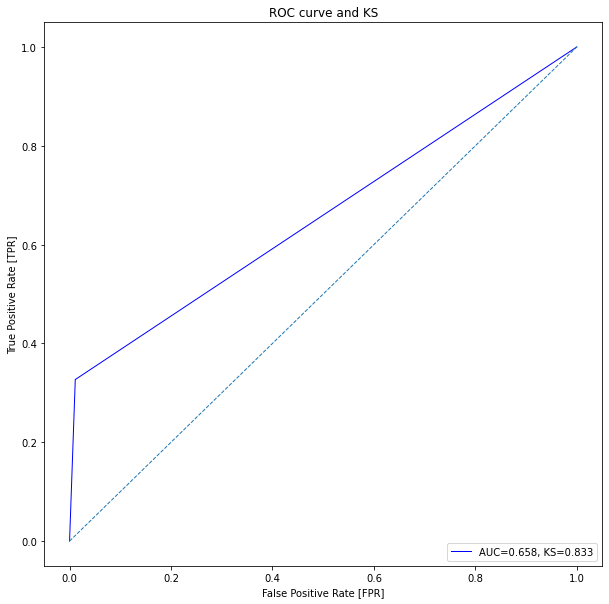

In [38]:
prob_test = model.predict_proba(X_test)[:,1]
      
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = round(auc(fpr, tpr),3)
KS= round(ks_2samp(fpr, tpr)[0],3) 

fig = plt.figure(figsize=(10,10)) # Init figure
plt.plot(fpr, tpr, 'b', linewidth=1, label="AUC="+str(roc_auc)+", KS="+str(KS)) # Plot ROC Curve
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=1,linestyle='dashed') # Plot dashed guess line
plt.legend(loc=4)
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('ROC curve and KS')  

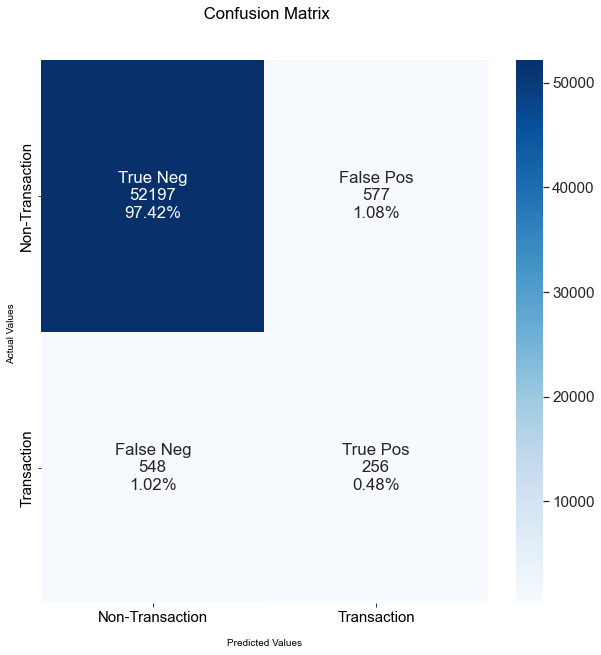

In [39]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

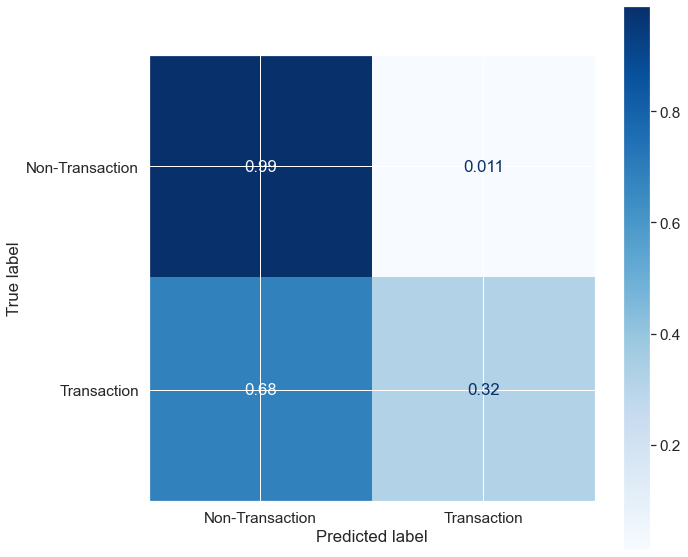

In [40]:
CM=confusion_matrix(y_test, preds_test,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')


1.1.2 Caso simple (train_test_split) con dataframe data_norm

In [41]:
# SIMPLE. Enfoque de validación de HoldOut
X_train, X_test, y_train, y_test = train_test_split(data_norm.drop(labels=['transaction', ], axis=1),data_norm['transaction'], test_size=0.2, random_state=0, stratify=data_norm['transaction'])

model = DecisionTreeClassifier(random_state=1)

model.fit(X_train, y_train)
preds_test= model.predict(X_test)
prob_test= model.predict_proba(X_test)[:,1]

print('ACC : %.3f' % accuracy_score(y_test, preds_test))
print('Precision  : %.3f' %  precision_score(y_test, preds_test))
print('Recall : %.3f' % recall_score(y_test, preds_test))
print('BACC : %.3f' % balanced_accuracy_score(y_test, preds_test))
print('F1-Score : %.3f' % f1_score(y_test, preds_test))
print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

ACC : 0.979
Precision  : 0.307
Recall : 0.318
BACC : 0.654
F1-Score : 0.313
AUC-ROC : 0.658
MCC : 0.302


Text(0.5, 1.0, 'ROC curve and KS')

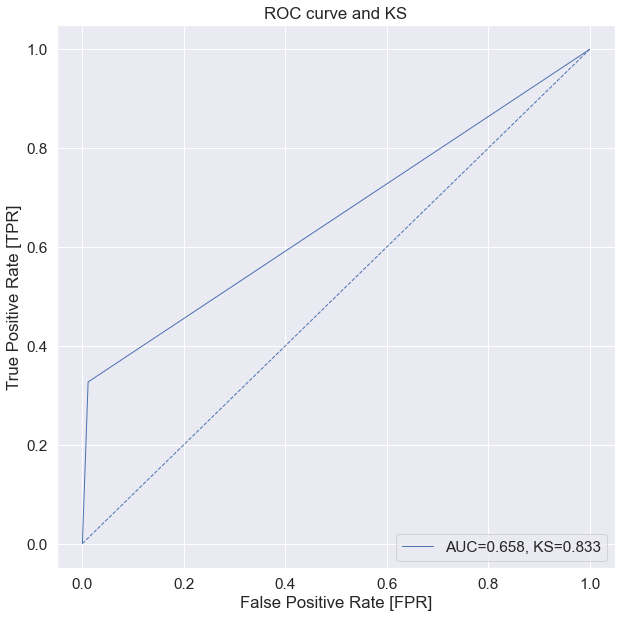

In [42]:
prob_test = model.predict_proba(X_test)[:,1]
      
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = round(auc(fpr, tpr),3)
KS= round(ks_2samp(fpr, tpr)[0],3) 

fig = plt.figure(figsize=(10,10)) # Init figure
plt.plot(fpr, tpr, 'b', linewidth=1, label="AUC="+str(roc_auc)+", KS="+str(KS)) # Plot ROC Curve
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=1,linestyle='dashed') # Plot dashed guess line
plt.legend(loc=4)
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('ROC curve and KS')  

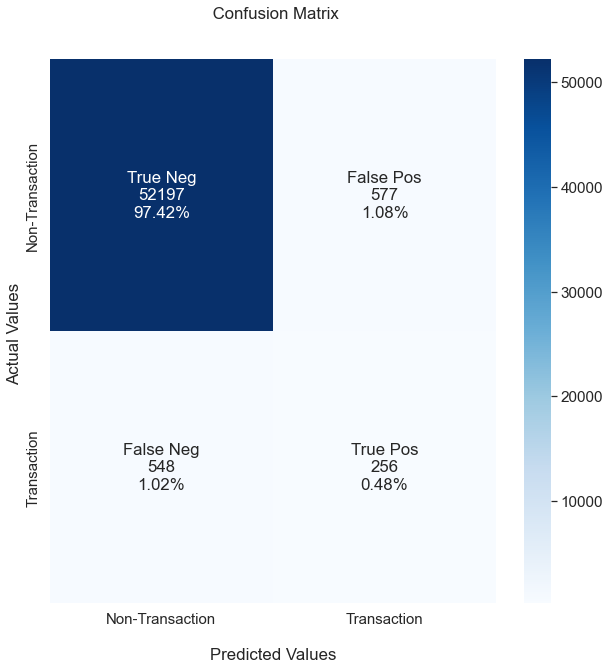

In [43]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

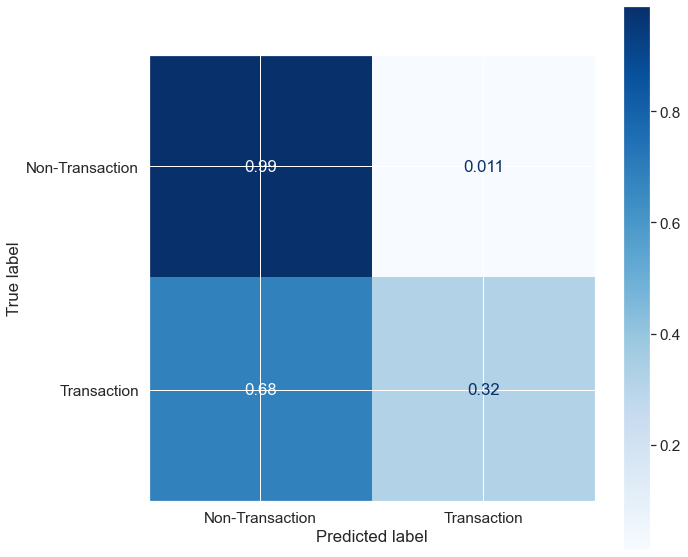

In [44]:
CM=confusion_matrix(y_test, preds_test,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

1.1.3 Caso simple con dataframe Data_Encod

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_encod.drop(labels=['transaction', ], axis=1),data_encod['transaction'], test_size=0.2, random_state=0, stratify=data_encod['transaction'])

model = DecisionTreeClassifier(random_state=1)

model.fit(X_train, y_train)
preds_test= model.predict(X_test)
prob_test= model.predict_proba(X_test)[:,1]

print('ACC : %.3f' % accuracy_score(y_test, preds_test))
print('Precision  : %.3f' %  precision_score(y_test, preds_test))
print('Recall : %.3f' % recall_score(y_test, preds_test))
print('BACC : %.3f' % balanced_accuracy_score(y_test, preds_test))
print('F1-Score : %.3f' % f1_score(y_test, preds_test))
print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

ACC : 0.978
Precision  : 0.281
Recall : 0.295
BACC : 0.642
F1-Score : 0.288
AUC-ROC : 0.648
MCC : 0.277


Text(0.5, 1.0, 'ROC curve and KS')

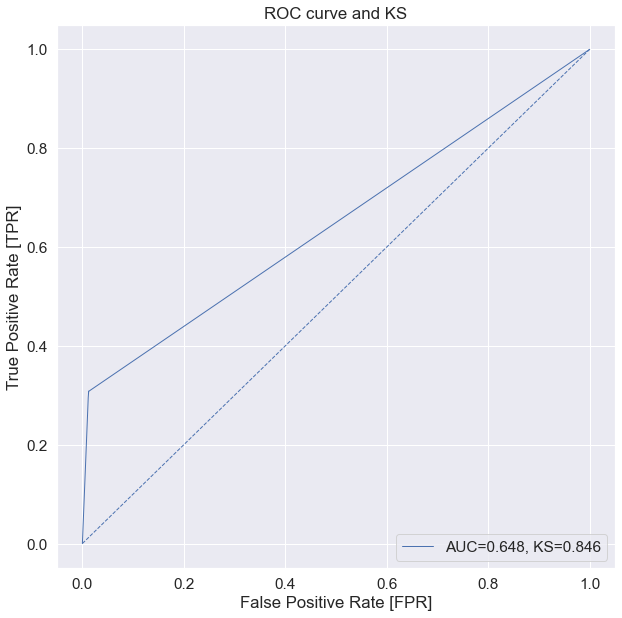

In [46]:
prob_test = model.predict_proba(X_test)[:,1]
      
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = round(auc(fpr, tpr),3)
KS= round(ks_2samp(fpr, tpr)[0],3) 

fig = plt.figure(figsize=(10,10)) # Init figure
plt.plot(fpr, tpr, 'b', linewidth=1, label="AUC="+str(roc_auc)+", KS="+str(KS)) # Plot ROC Curve
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=1,linestyle='dashed') # Plot dashed guess line
plt.legend(loc=4)
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('ROC curve and KS')  

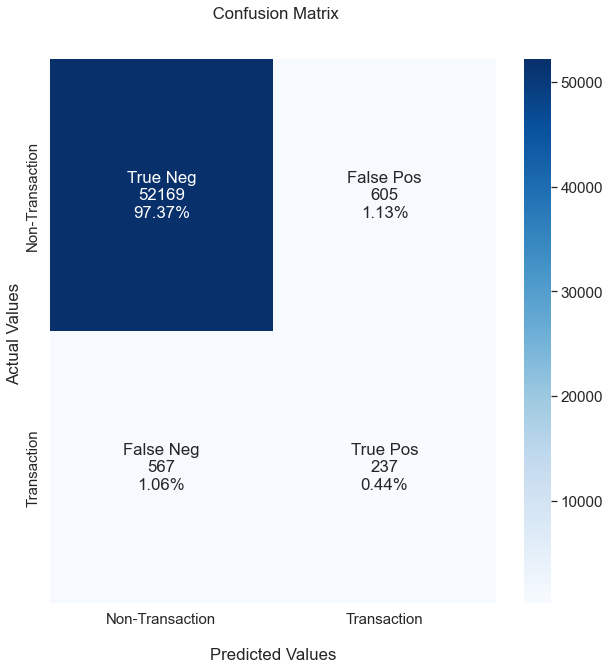

In [47]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

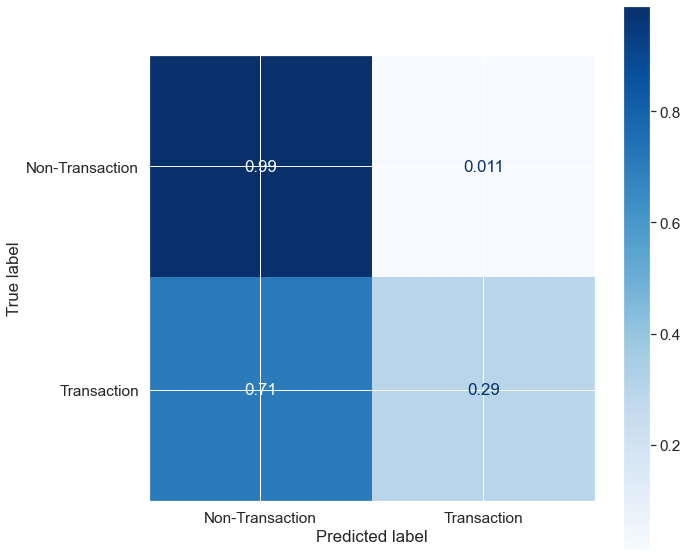

In [48]:
CM=confusion_matrix(y_test, preds_test,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

1.2 Cross validation

1.2.1 Cross-validation con dataframe data_dummies

In [49]:
# K Fold Cross Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(labels=['transaction', ], axis=1),data_dummies['transaction'], test_size=0.2, random_state=0, stratify=data_dummies['transaction'])

model = DecisionTreeClassifier(random_state=1)
kfold_validation=KFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.9994633916447746
Metricas cross validation [0.97918903 0.97984228 0.97998227 0.97895572 0.98170874 0.97778918
 0.98044888 0.9784891  0.97732257 0.97960803]
ACC: 0.979 (0.001)
Precision: 0.311 (0.018)
Recall: 0.310 (0.018)
BACC: 0.650 (0.009)
F1: 0.310 (0.015)


In [50]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9790025756840495


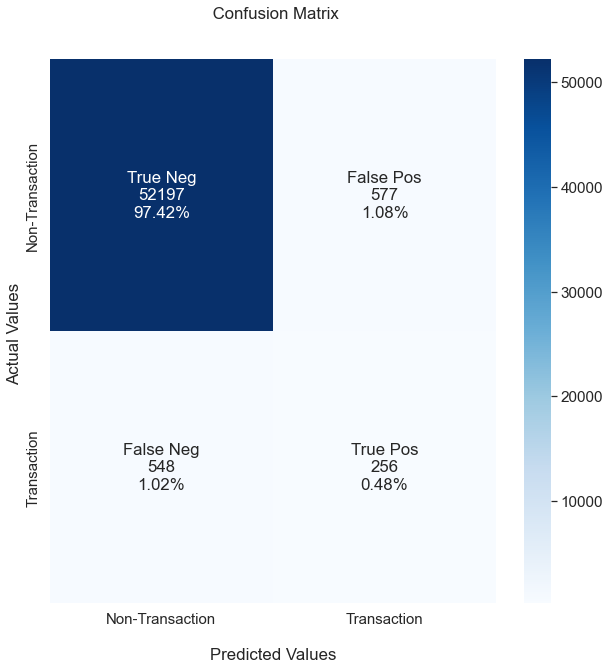

In [51]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

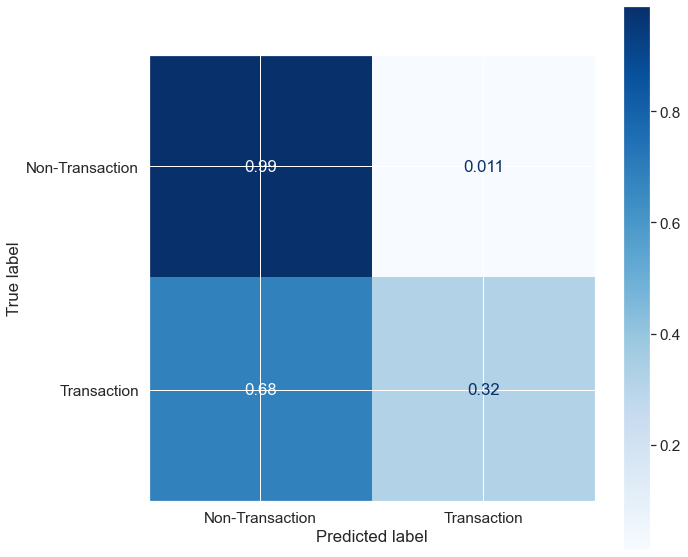

In [52]:
CM=confusion_matrix(y_test, preds,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

In [53]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.978 (0.002)


In [54]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

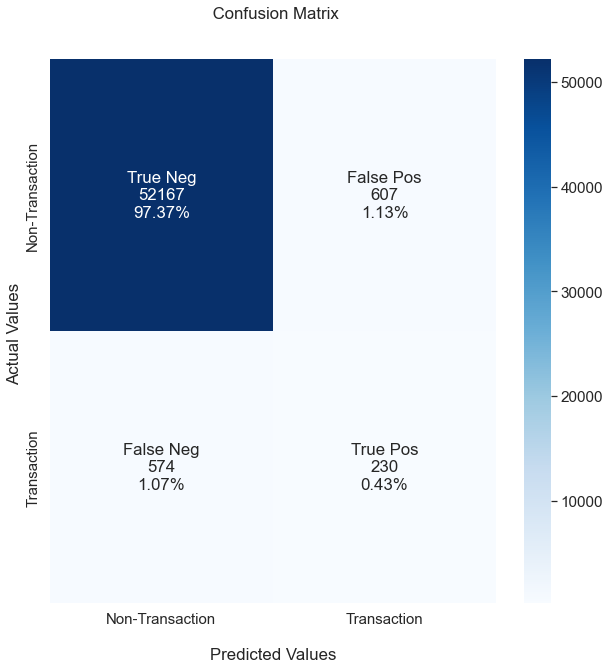

In [55]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()


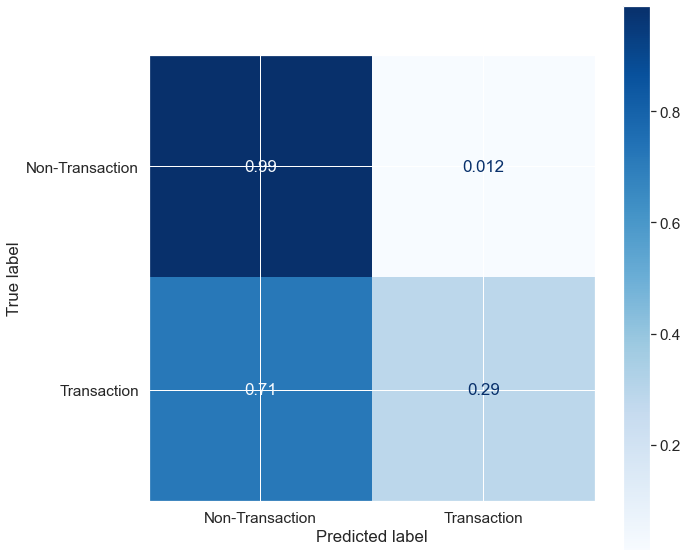

In [56]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

1.2.2 Cross-validation con dataframe data_encod

In [57]:
# K Fold Cross Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_encod.drop(labels=['transaction', ], axis=1),data_encod['transaction'], test_size=0.2, random_state=0, stratify=data_encod['transaction'])

model = DecisionTreeClassifier(random_state=1)
kfold_validation=KFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.998982777204877
Metricas cross validation [0.97956232 0.97853577 0.97932901 0.97750922 0.97951565 0.97769586
 0.97760254 0.97680929 0.97755588 0.97816146]
ACC: 0.978 (0.001)
Precision: 0.272 (0.030)
Recall: 0.270 (0.029)
BACC: 0.629 (0.014)
F1: 0.270 (0.028)


In [58]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9781253499570719


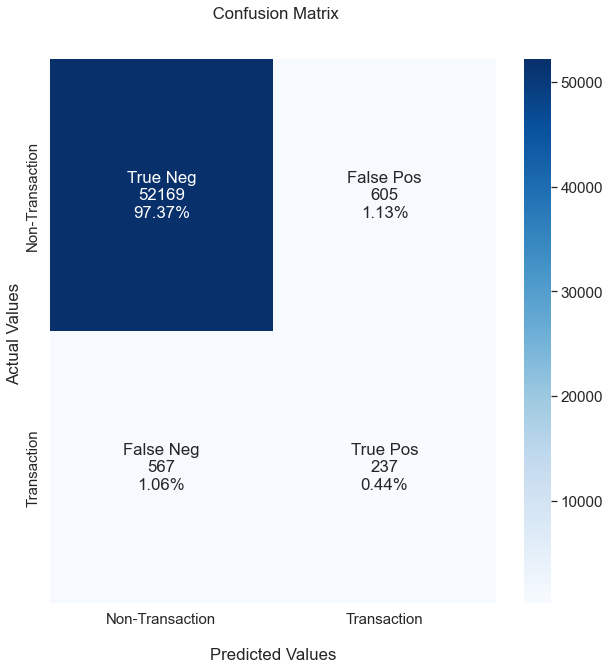

In [59]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

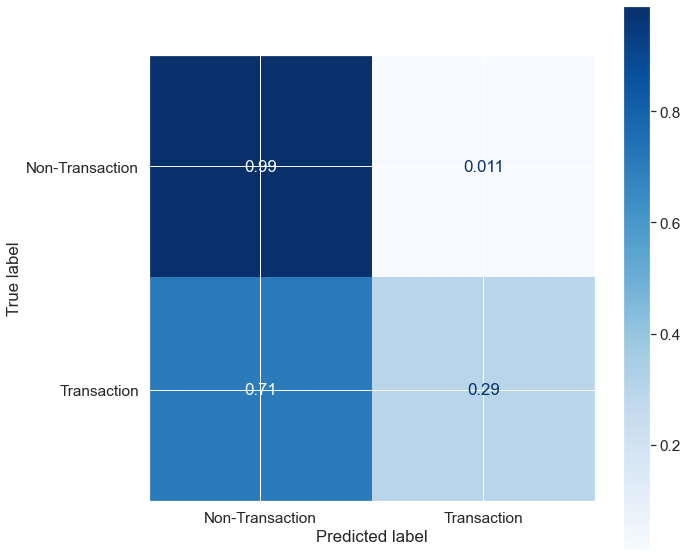

In [60]:
CM=confusion_matrix(y_test, preds,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

In [61]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.978 (0.002)


In [62]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

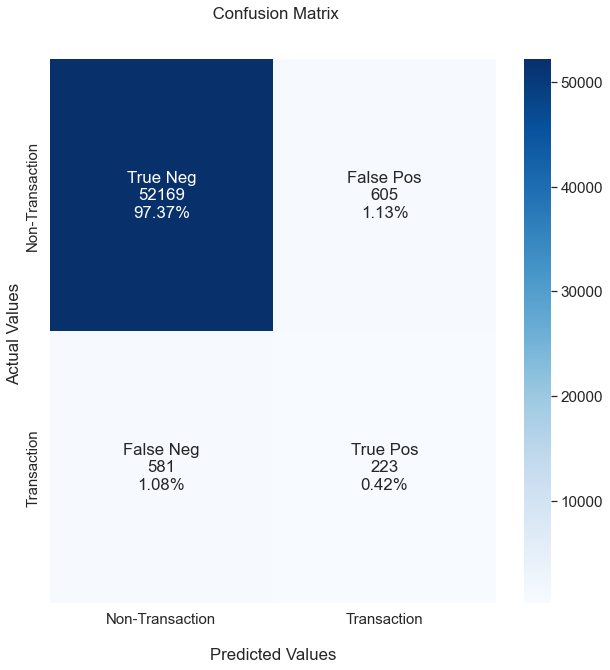

In [63]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

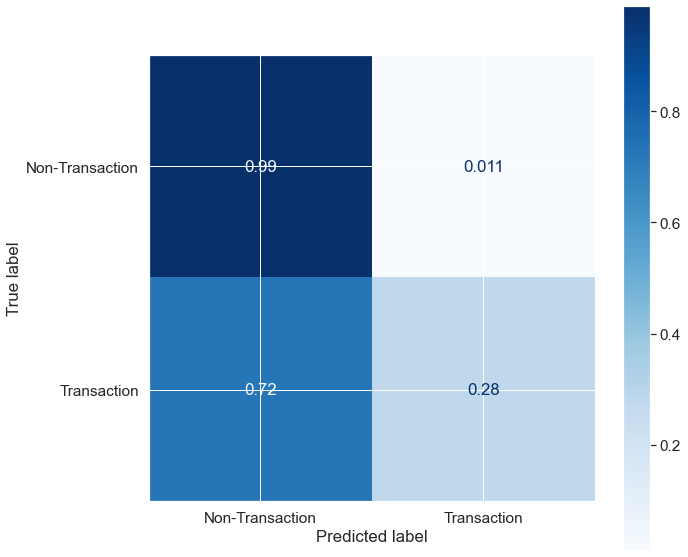

In [64]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

1.3 Stratified k-fold

1.3.1 Stratified k-fold con dataframe data_dummies

In [65]:
# Stratified K Fold Cross Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(labels=['transaction', ], axis=1),data_dummies['transaction'], test_size=0.2, random_state=0, stratify=data_dummies['transaction'])

model = DecisionTreeClassifier(random_state=1)
kfold_validation=StratifiedKFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))


Metrica del modelo 0.9994633916447746
Metricas cross validation [0.97914236 0.98058887 0.97881573 0.97928235 0.98012225 0.97914236
 0.97918903 0.97918903 0.97760254 0.97993467]
ACC: 0.979 (0.001)
Precision: 0.314 (0.022)
Recall: 0.319 (0.023)
BACC: 0.654 (0.011)
F1: 0.316 (0.022)


In [66]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9790025756840495


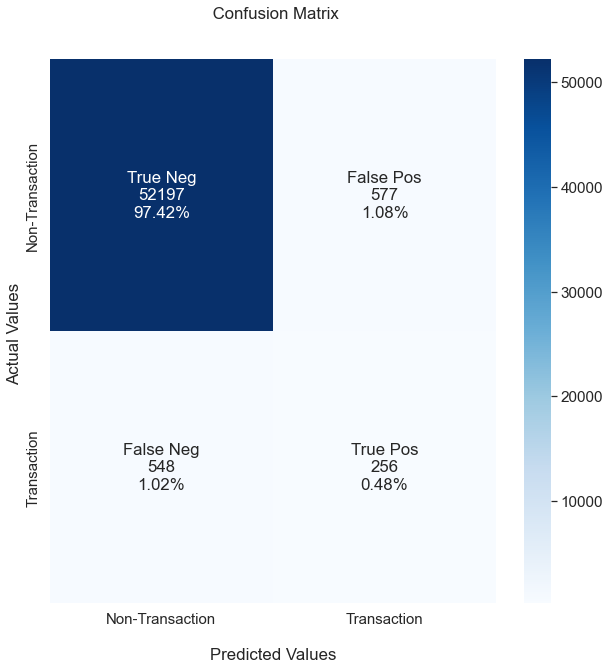

In [67]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

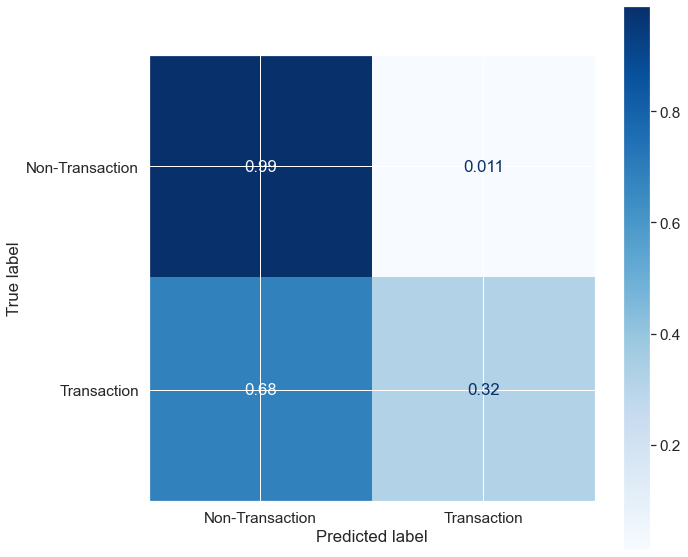

In [68]:
CM=confusion_matrix(y_test, preds,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

In [69]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.978 (0.002)


In [70]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

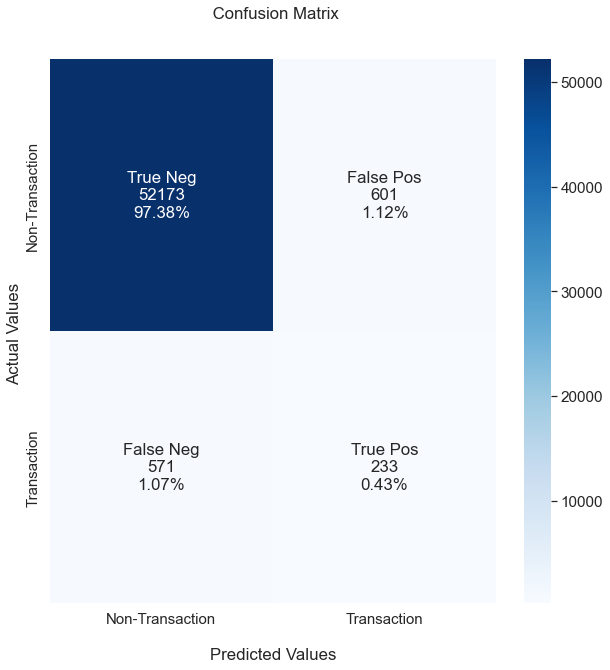

In [71]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

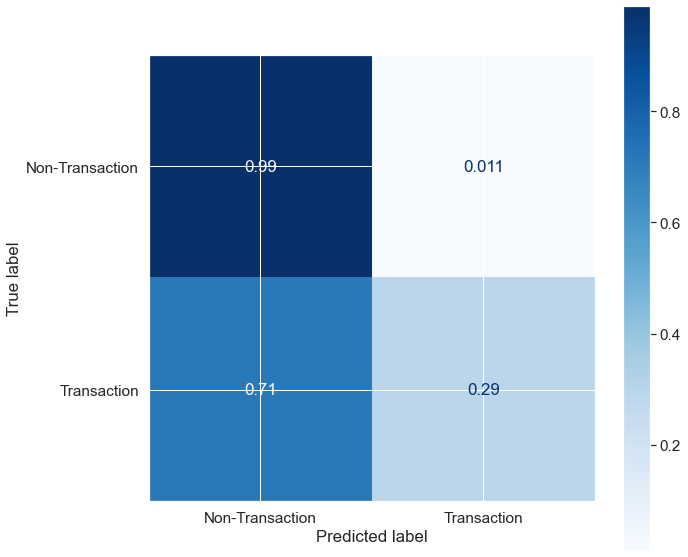

In [72]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

1.3.2 Stratified k-fold con dataframe data_encod

In [73]:
# Stratified K Fold Cross Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_encod.drop(labels=['transaction', ], axis=1),data_encod['transaction'], test_size=0.2, random_state=0, stratify=data_encod['transaction'])

model = DecisionTreeClassifier(random_state=1)
kfold_validation=StratifiedKFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.998982777204877
Metricas cross validation [0.97932901 0.97834912 0.97830246 0.97853577 0.97788251 0.97788251
 0.97774252 0.97750922 0.97820914 0.97774148]
ACC: 0.978 (0.000)
Precision: 0.271 (0.021)
Recall: 0.271 (0.034)
BACC: 0.630 (0.017)
F1: 0.271 (0.027)


In [74]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9781253499570719


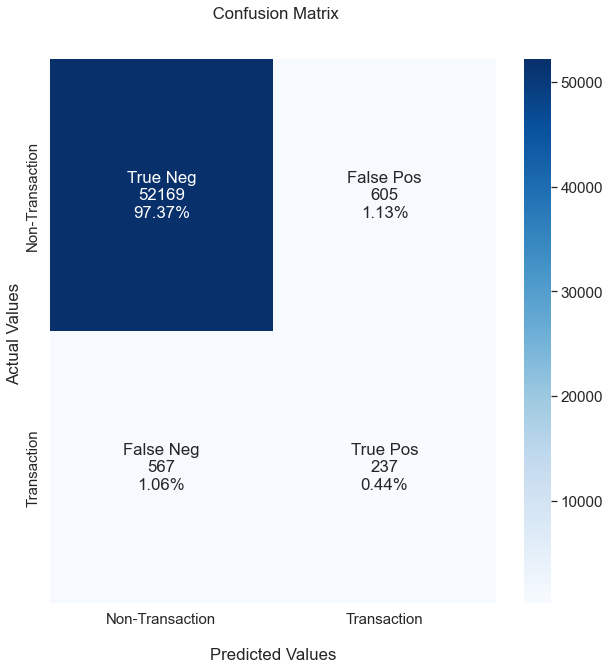

In [75]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

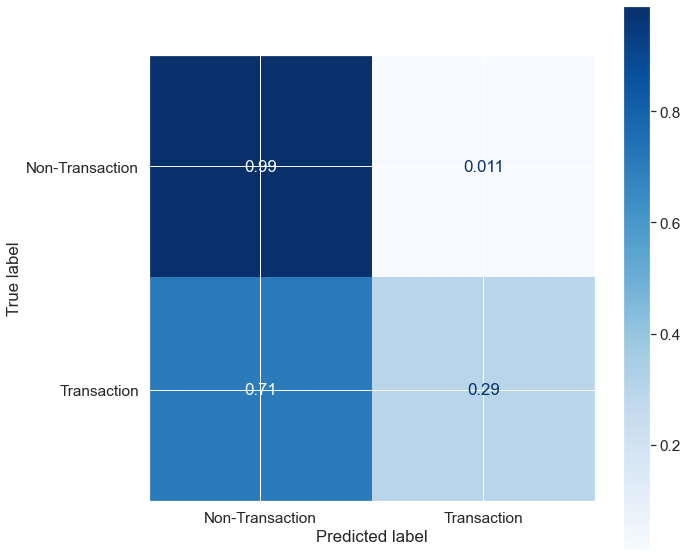

In [76]:
CM=confusion_matrix(y_test, preds,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

In [77]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.977 (0.001)


In [78]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

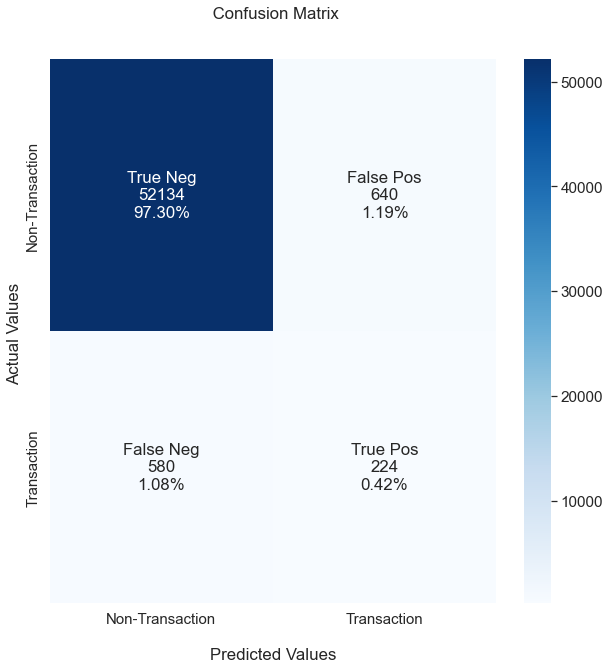

In [79]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

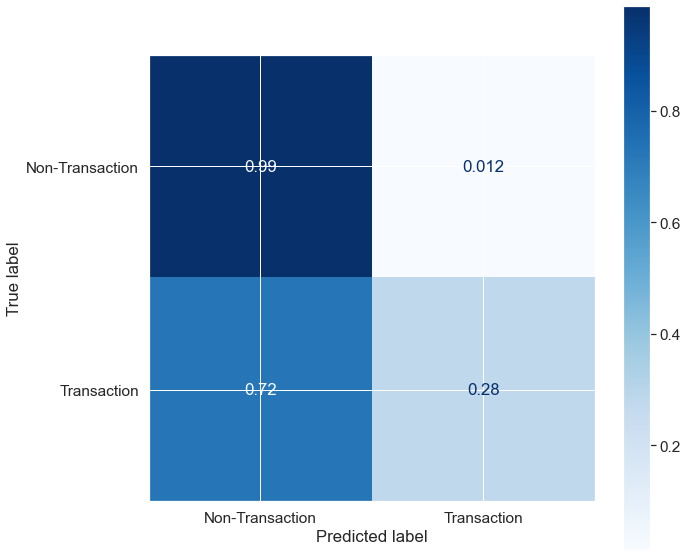

In [80]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

### 2. Clasificador Random Forest

2.1 Caso simple

2.1.1 Caso simple con dataframe data_dummies

In [81]:
# SIMPLE. Enfoque de validación de HoldOut

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(labels=['transaction', ], axis=1),data_dummies['transaction'], test_size=0.2, random_state=0, stratify=data_dummies['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)

model.fit(X_train, y_train)
preds_test= model.predict(X_test)
prob_test= model.predict_proba(X_test)[:,1]

print('ACC : %.3f' % accuracy_score(y_test, preds_test))
print('Precision  : %.3f' %  precision_score(y_test, preds_test))
print('Recall : %.3f' % recall_score(y_test, preds_test))
print('BACC : %.3f' % balanced_accuracy_score(y_test, preds_test))
print('F1-Score : %.3f' % f1_score(y_test, preds_test))
print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

ACC : 0.982
Precision  : 0.366
Recall : 0.234
BACC : 0.614
F1-Score : 0.285
AUC-ROC : 0.914
MCC : 0.284


Text(0.5, 1.0, 'ROC curve and KS')

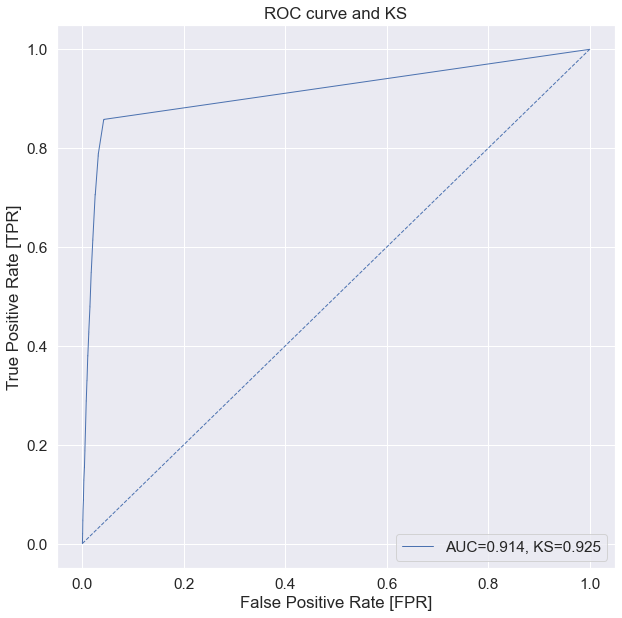

In [82]:
prob_test = model.predict_proba(X_test)[:,1]
      
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = round(auc(fpr, tpr),3)
KS= round(ks_2samp(fpr, tpr)[0],3) 

fig = plt.figure(figsize=(10,10)) # Init figure
plt.plot(fpr, tpr, 'b', linewidth=1, label="AUC="+str(roc_auc)+", KS="+str(KS)) # Plot ROC Curve
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=1,linestyle='dashed') # Plot dashed guess line
plt.legend(loc=4)
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('ROC curve and KS') 

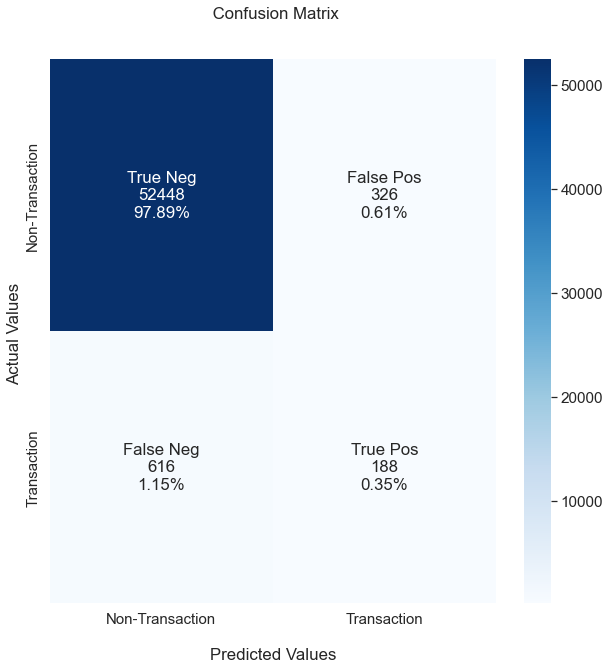

In [83]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

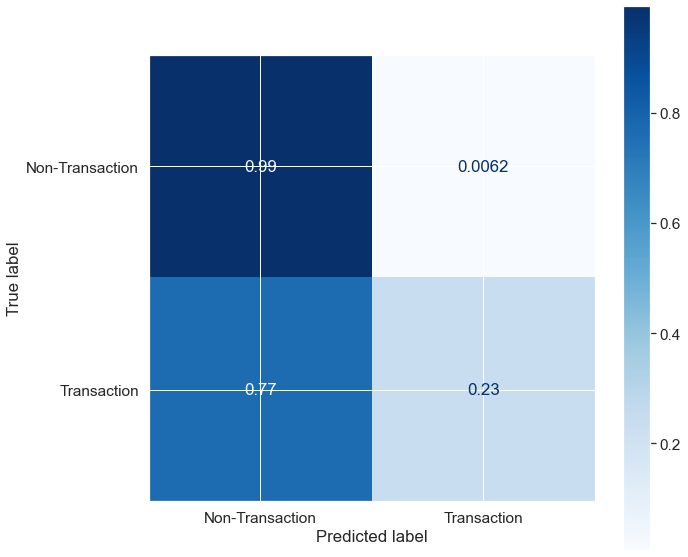

In [84]:
CM=confusion_matrix(y_test, preds_test,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

2.1.2 Caso simple con dataframe data_norm

In [85]:
# SIMPLE. Enfoque de validación de HoldOut

X_train, X_test, y_train, y_test = train_test_split(data_norm.drop(labels=['transaction', ], axis=1),data_norm['transaction'], test_size=0.2, random_state=0, stratify=data_norm['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)

model.fit(X_train, y_train)
preds_test= model.predict(X_test)
prob_test= model.predict_proba(X_test)[:,1]

print('ACC : %.3f' % accuracy_score(y_test, preds_test))
print('Precision  : %.3f' %  precision_score(y_test, preds_test))
print('Recall : %.3f' % recall_score(y_test, preds_test))
print('BACC : %.3f' % balanced_accuracy_score(y_test, preds_test))
print('F1-Score : %.3f' % f1_score(y_test, preds_test))
print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

ACC : 0.982
Precision  : 0.366
Recall : 0.234
BACC : 0.614
F1-Score : 0.285
AUC-ROC : 0.914
MCC : 0.284


Text(0.5, 1.0, 'ROC curve and KS')

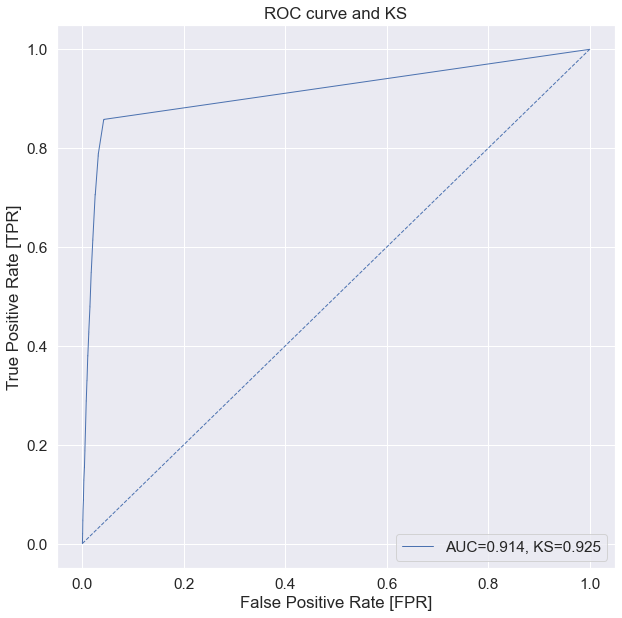

In [86]:
prob_test = model.predict_proba(X_test)[:,1]
      
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = round(auc(fpr, tpr),3)
KS= round(ks_2samp(fpr, tpr)[0],3) 

fig = plt.figure(figsize=(10,10)) # Init figure
plt.plot(fpr, tpr, 'b', linewidth=1, label="AUC="+str(roc_auc)+", KS="+str(KS)) # Plot ROC Curve
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=1,linestyle='dashed') # Plot dashed guess line
plt.legend(loc=4)
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('ROC curve and KS') 

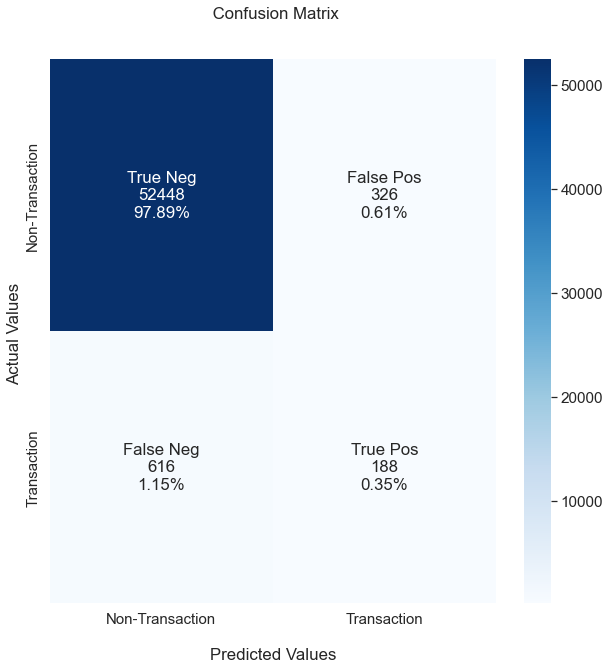

In [87]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

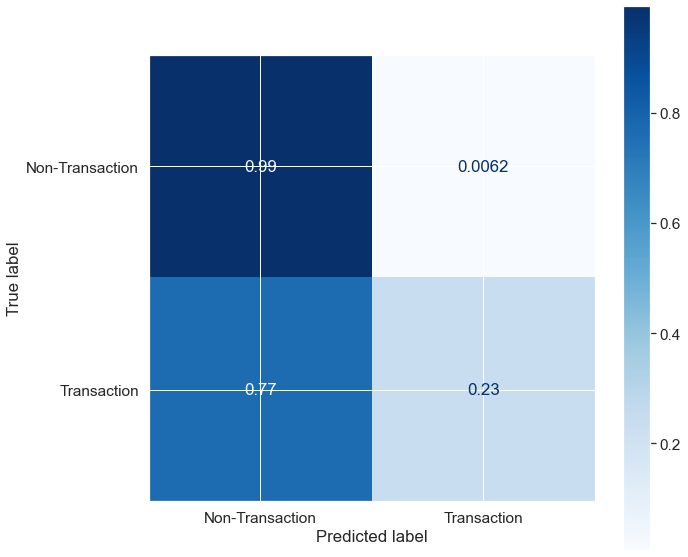

In [88]:
CM=confusion_matrix(y_test, preds_test,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

2.1.3 Caso simple con dataframe data_encod

In [89]:
# SIMPLE. Enfoque de validación de HoldOut

X_train, X_test, y_train, y_test = train_test_split(data_encod.drop(labels=['transaction', ], axis=1),data_encod['transaction'], test_size=0.2, random_state=0, stratify=data_encod['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)

model.fit(X_train, y_train)
preds_test= model.predict(X_test)
prob_test= model.predict_proba(X_test)[:,1]

print('ACC : %.3f' % accuracy_score(y_test, preds_test))
print('Precision  : %.3f' %  precision_score(y_test, preds_test))
print('Recall : %.3f' % recall_score(y_test, preds_test))
print('BACC : %.3f' % balanced_accuracy_score(y_test, preds_test))
print('F1-Score : %.3f' % f1_score(y_test, preds_test))
print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

ACC : 0.981
Precision  : 0.317
Recall : 0.220
BACC : 0.606
F1-Score : 0.260
AUC-ROC : 0.900
MCC : 0.255


Text(0.5, 1.0, 'ROC curve and KS')

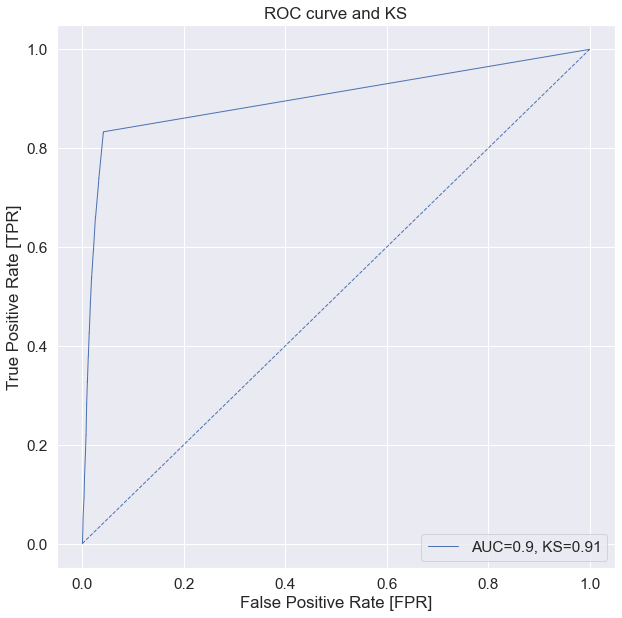

In [90]:
prob_test = model.predict_proba(X_test)[:,1]
      
fpr, tpr, threshold = roc_curve(y_test, prob_test)
roc_auc = round(auc(fpr, tpr),3)
KS= round(ks_2samp(fpr, tpr)[0],3) 

fig = plt.figure(figsize=(10,10)) # Init figure
plt.plot(fpr, tpr, 'b', linewidth=1, label="AUC="+str(roc_auc)+", KS="+str(KS)) # Plot ROC Curve
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linewidth=1,linestyle='dashed') # Plot dashed guess line
plt.legend(loc=4)
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]')
plt.title('ROC curve and KS') 

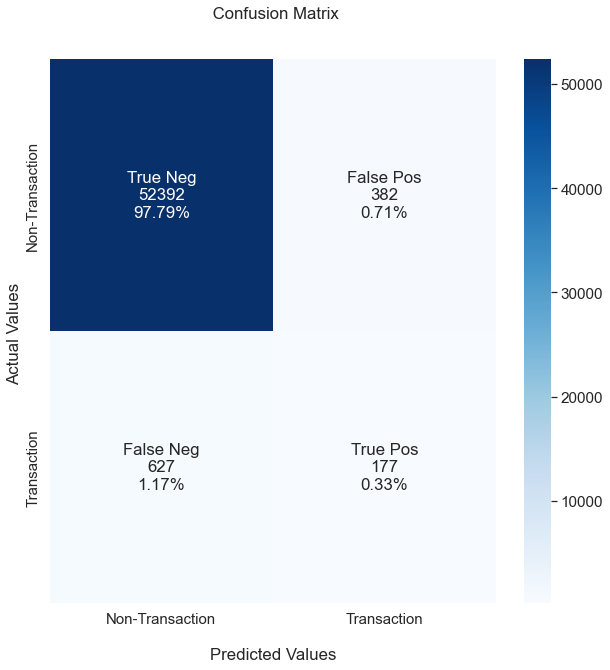

In [91]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

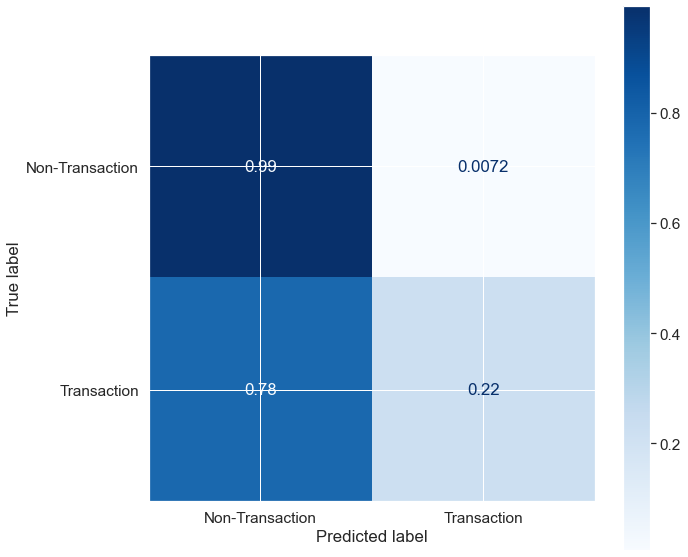

In [92]:
CM=confusion_matrix(y_test, preds_test,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

2.2 Cross-validation

2.2.1 Cross-validation con dataframe data_dummies

In [93]:
# K Fold Cross Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(labels=['transaction', ], axis=1),data_dummies['transaction'], test_size=0.2, random_state=0, stratify=data_dummies['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)
kfold_validation=KFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.9987448030647337
Metricas cross validation [0.98278195 0.9829686  0.98259531 0.98254864 0.98399515 0.98170874
 0.98338855 0.98040222 0.98049554 0.98315446]
ACC: 0.982 (0.001)
Precision: 0.365 (0.031)
Recall: 0.235 (0.022)
BACC: 0.614 (0.011)
F1: 0.285 (0.024)


In [94]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9824181567061108


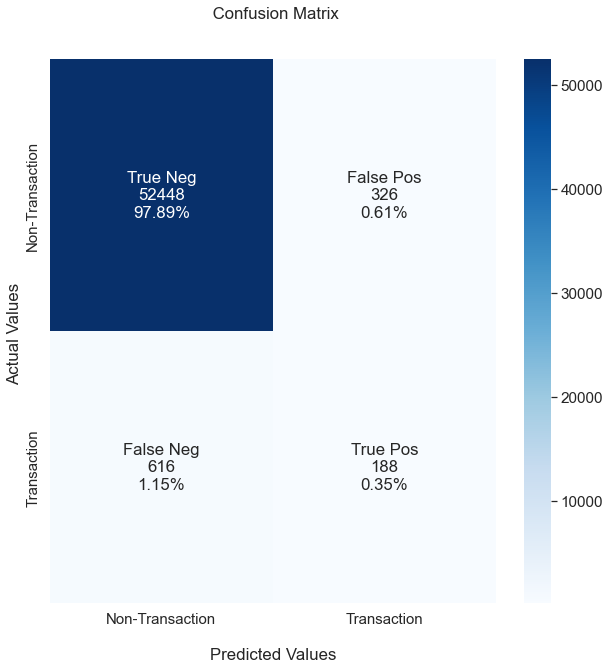

In [95]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

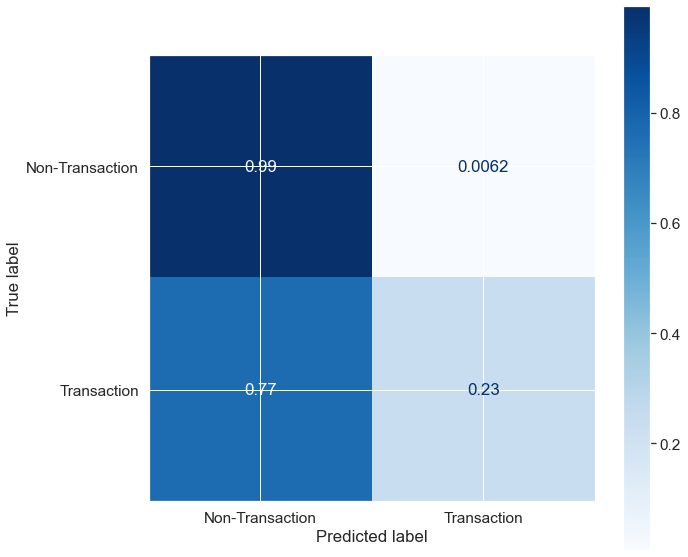

In [96]:
CM=confusion_matrix(y_test, preds,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

In [97]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.982 (0.001)


In [98]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

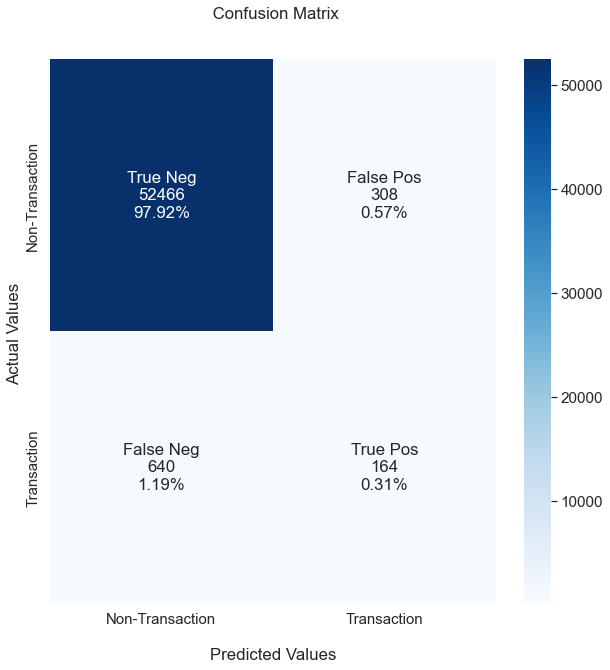

In [99]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

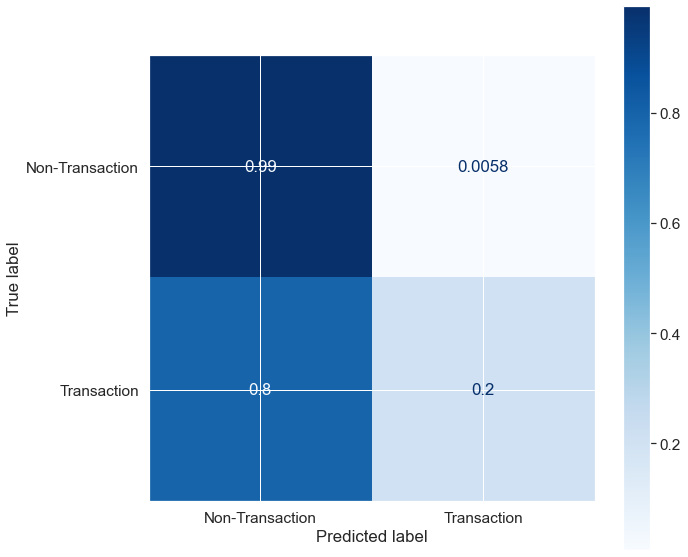

In [100]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

2.2.2 Cross-validation con dataframe data_encod

In [101]:
# K Fold Cross Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_encod.drop(labels=['transaction', ], axis=1),data_encod['transaction'], test_size=0.2, random_state=0, stratify=data_encod['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)
kfold_validation=KFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.9982175270287296
Metricas cross validation [0.98138211 0.98072885 0.98152209 0.98021558 0.98212869 0.97965564
 0.98189539 0.97988895 0.97965564 0.98175455]
ACC: 0.981 (0.001)
Precision: 0.292 (0.021)
Recall: 0.193 (0.018)
BACC: 0.593 (0.009)
F1: 0.232 (0.016)


In [102]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9811676434357386


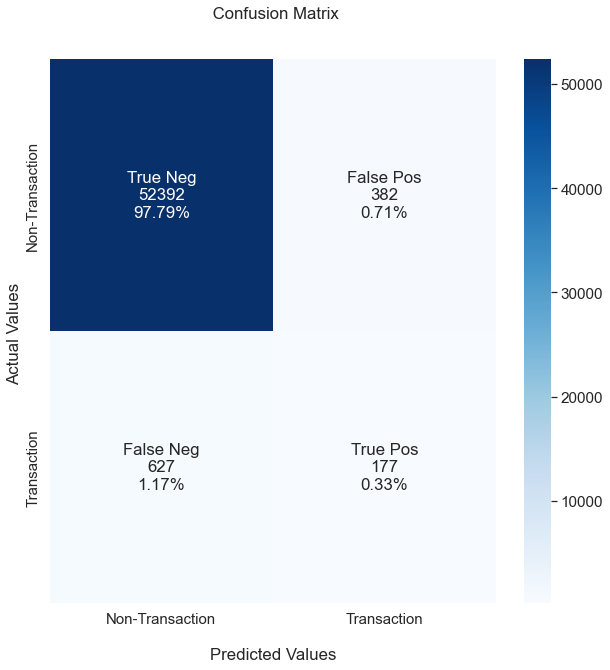

In [103]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

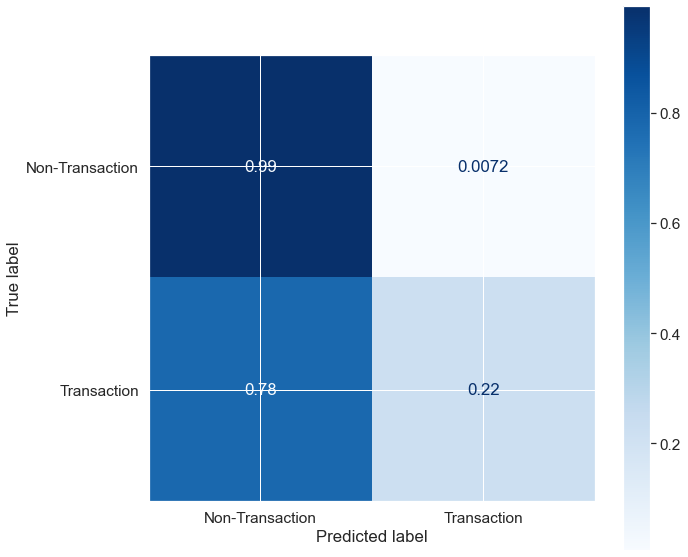

In [104]:
CM=confusion_matrix(y_test, preds,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

In [105]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.982 (0.001)


In [106]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

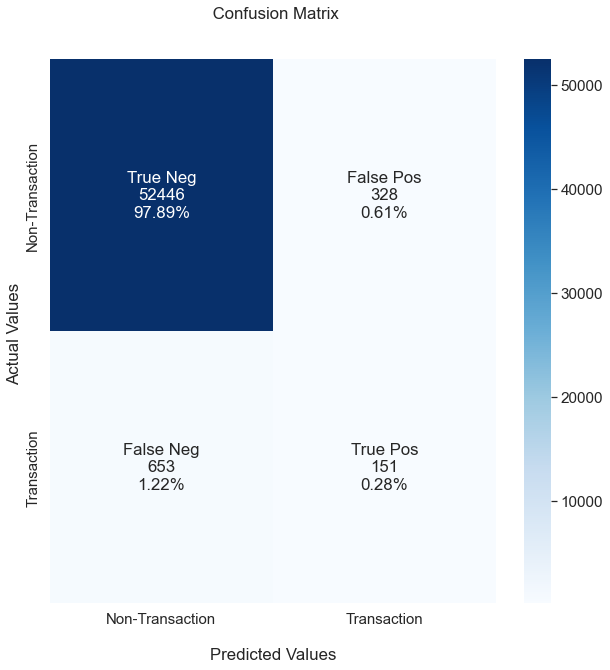

In [107]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

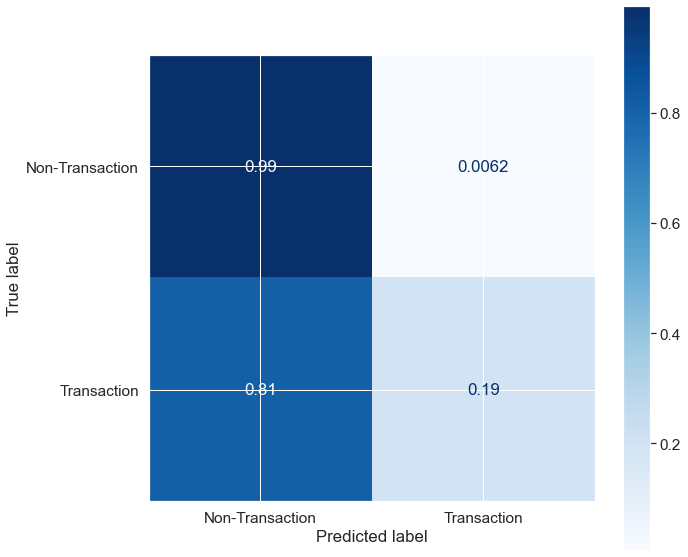

In [108]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

2.3 Stratified k-fold

2.3.1 Stratified k-fold con dataframe data_dummies

In [109]:
# Stratified K Fold Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(labels=['transaction', ], axis=1),data_dummies['transaction'], test_size=0.2, random_state=0, stratify=data_dummies['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)
Stratified_kfold_validation=StratifiedKFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.9987448030647337
Metricas cross validation [0.98254864 0.9829686  0.98268863 0.98264197 0.98240866 0.98254864
 0.98194205 0.98250198 0.98142877 0.98278115]
ACC: 0.982 (0.000)
Precision: 0.365 (0.023)
Recall: 0.231 (0.021)
BACC: 0.612 (0.010)
F1: 0.283 (0.022)


In [110]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9824181567061108


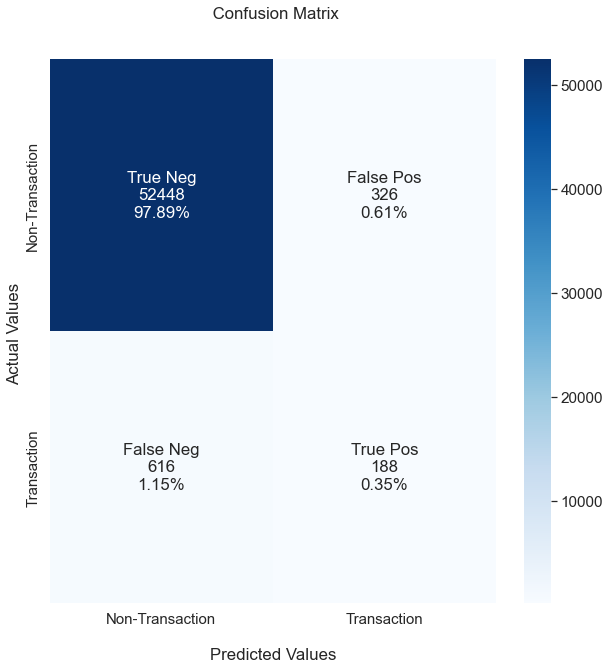

In [111]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

In [112]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.982 (0.001)


In [113]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

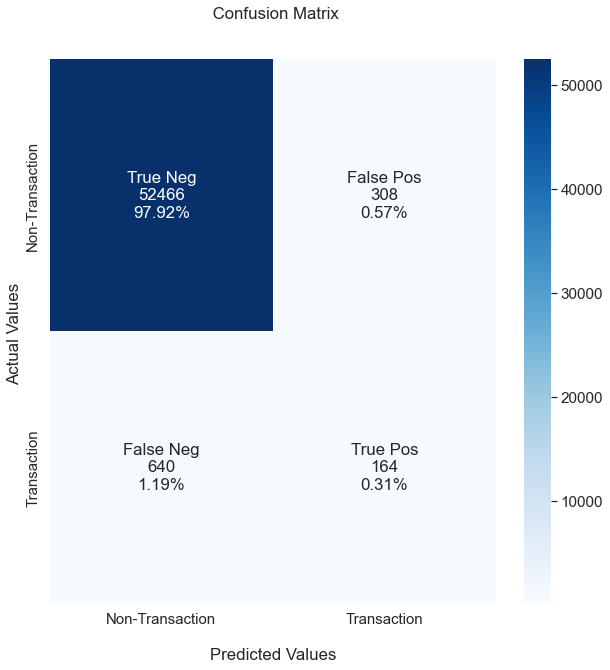

In [114]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

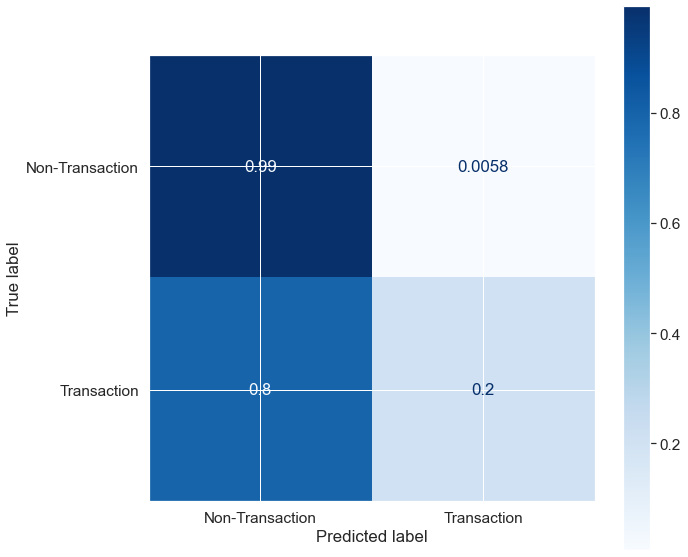

In [115]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')

2.3.2 Stratified k-fold con dataframe data_encod

In [116]:
# Stratified K Fold Validation 

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data_encod.drop(labels=['transaction', ], axis=1),data_encod['transaction'], test_size=0.2, random_state=0, stratify=data_encod['transaction'])

model = RandomForestClassifier(n_estimators=20, random_state=101)
Stratified_kfold_validation=StratifiedKFold(10)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print("Metrica del modelo", score)

#evaluamos el modelo

results_ACC=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='accuracy')
results_Precision=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='precision')
results_Recall=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='recall')
results_BACC=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='balanced_accuracy')
results_F1=cross_val_score(model,X_train,y_train,cv=Stratified_kfold_validation, scoring='f1')

print("Metricas cross validation", results_ACC)

#print('AUC-ROC : %.3f' % roc_auc_score(y_test, prob_test))
#print('MCC : %.3f' % matthews_corrcoef(y_test, preds_test))

print("ACC: %.3f (%.3f)" % (results_ACC.mean(), results_ACC.std()))
print("Precision: %.3f (%.3f)" % (results_Precision.mean(), results_Precision.std()))
print("Recall: %.3f (%.3f)" % (results_Recall.mean(), results_Recall.std()))
print("BACC: %.3f (%.3f)" % (results_BACC.mean(), results_BACC.std()))
print("F1: %.3f (%.3f)" % (results_F1.mean(), results_F1.std()))

Metrica del modelo 0.9982175270287296
Metricas cross validation [0.98119546 0.9817554  0.98049554 0.97998227 0.98100882 0.98138211
 0.98096216 0.98072885 0.98077551 0.9815679 ]
ACC: 0.981 (0.000)
Precision: 0.293 (0.029)
Recall: 0.191 (0.027)
BACC: 0.592 (0.013)
F1: 0.231 (0.028)


In [117]:
preds = model.predict(X_test)
score_pred = metrics.accuracy_score(y_test, preds)
print("Metrica en test", score_pred)

Metrica en test 0.9811676434357386


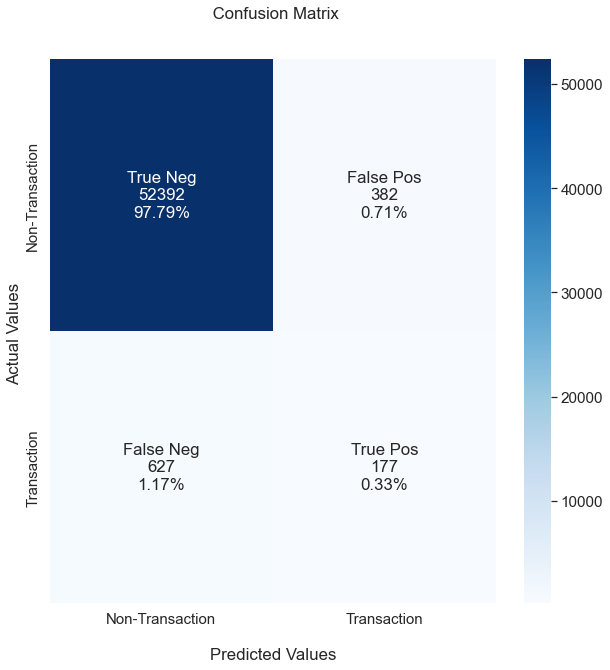

In [118]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

In [119]:
testing_score = cross_val_score(model, X_test, y_test, cv=kfold_validation, scoring='accuracy')
print("ACC: %.3f (%.3f)" % (testing_score.mean(), testing_score.std()))

ACC: 0.982 (0.001)


In [120]:
testing_predictions = cross_val_predict(model, X_test, y_test, cv=kfold_validation)

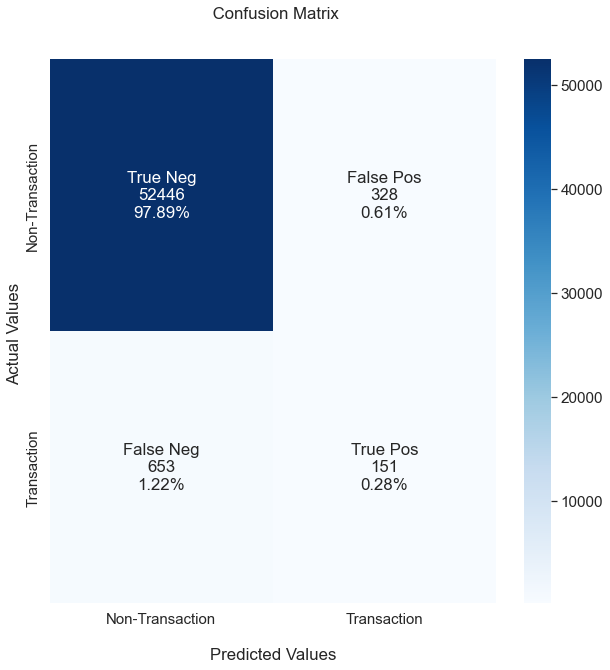

In [121]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, testing_predictions)

#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))  
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - 
ax.xaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)
ax.yaxis.set_ticklabels(['Non-Transaction','Transaction'],fontsize = 15)

## Display the visualization of the Confusion Matrix.
plt.show()

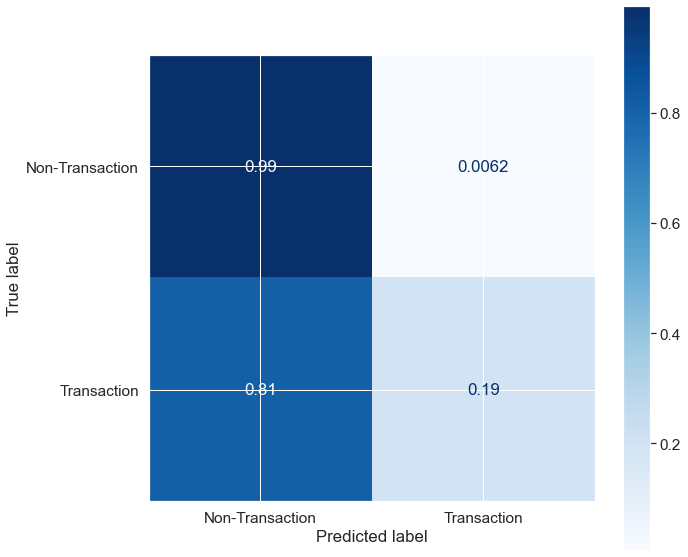

In [122]:
CM=confusion_matrix(y_test, testing_predictions,  normalize='true')#normalize{‘true’, ‘pred’, ‘all’}, default=None

CMD=ConfusionMatrixDisplay(CM,display_labels=['Non-Transaction','Transaction'])
fig, ax = plt.subplots(figsize=(10,10))
CMD.plot(ax=ax,cmap='Blues')